In [ ]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import cv2

In [ ]:
import kaggle

OSError: ignored

In [ ]:
! mv kaggle.json /root/.kaggle/
import kaggle


In [ ]:
! kaggle competitions download -c dog-breed-identification # Downloading dataset

 97% 670M/691M [00:06<00:00, 183MB/s]
100% 691M/691M [00:06<00:00, 107MB/s]


In [ ]:
! unzip -q dog-breed-identification.zip

In [ ]:
label=pd.read_csv('/content/labels.csv') # Loading labels
label.head(4)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick


In [ ]:
label['id']=label['id']+'.jpg'

In [ ]:
label.head(4)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick


In [ ]:
# Image data generator
idg=tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                    width_shift_range=20,
                                                    height_shift_range=30,
                                                    horizontal_flip=True,
                                                    vertical_flip=False,
                                                    validation_split=0.1,
                                                    preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

In [ ]:
b=64

In [ ]:
train_idg=idg.flow_from_dataframe(label,'train/',x_col='id',y_col='breed',batch_size=b,
                                  target_size=(300,300),subset='training')

Found 9200 validated image filenames belonging to 120 classes.


In [ ]:
val_idg=idg.flow_from_dataframe(label,'train/',x_col='id',y_col='breed',batch_size=b,
                                  target_size=(300,300),subset='validation')

Found 1022 validated image filenames belonging to 120 classes.


In [ ]:
vgg16=tf.keras.applications.VGG16(include_top=False,input_shape=(300,300,3)) # Downloading VGG16 model

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg16.layers[1].name

'block1_conv1'

In [ ]:
vgg16.layers[1].trainable

True

In [ ]:
# freezing layers of vgg16
vgg16.trainable=False

In [ ]:
for i in vgg16.layers:
  print(i.name, i.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [ ]:
for i in vgg16.layers[-3:-1]:
  print(i.name, i.trainable)

block5_conv2 False
block5_conv3 False


In [ ]:
# Unfreezing last two layers of vgg16 model
for i in vgg16.layers[-3:-1]:
  i.trainable=True
  print(i.name, i.trainable)

block5_conv2 True
block5_conv3 True


In [ ]:
for i in vgg16.layers:
  print(i.name, i.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 True
block5_conv3 True
block5_pool False


In [ ]:
vgg16.output

<KerasTensor: shape=(None, 9, 9, 512) dtype=float32 (created by layer 'block5_pool')>

In [ ]:
# output block
flat=tf.keras.layers.GlobalAveragePooling2D() (vgg16.output)
dense1 = tf.keras.layers.Dense(units=512,activation='relu',name='Dense1') (flat)
dropout_1=tf.keras.layers.Dropout(rate=0.2,name='DropoutLayer1') (dense1)
dense2 = tf.keras.layers.Dense(units=256,activation='relu',name='Dense2') (dropout_1)
dropout_2=tf.keras.layers.Dropout(rate=0.2,name='DropoutLayer2') (dense2)
dense3 = tf.keras.layers.Dense(units=128,activation='relu',name='Dense3') (dropout_2)
dropout_3=tf.keras.layers.Dropout(rate=0.2,name='DropoutLayer3') (dense3)
dense4 = tf.keras.layers.Dense(units=64,activation='relu',name='Dense4') (dropout_3)
output = tf.keras.layers.Dense(units=120,activation='softmax',name='OutputLayer') (dense4)

In [ ]:
# Final model
model=tf.keras.models.Model(inputs=[vgg16.input], outputs=output)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(0.02),loss=tf.keras.losses.categorical_crossentropy,metrics=['acc'])

In [ ]:
model.fit(train_idg, batch_size=b, epochs=30, validation_data=val_idg)

Epoch 1/30
144/144 [==============================] - 315s 2s/step - loss: 4.7508 - acc: 0.0185 - val_loss: 4.5718 - val_acc: 0.0538
Epoch 2/30
144/144 [==============================] - 282s 2s/step - loss: 4.4005 - acc: 0.0673 - val_loss: 3.9790 - val_acc: 0.1125
Epoch 3/30
144/144 [==============================] - 266s 2s/step - loss: 3.7735 - acc: 0.1417 - val_loss: 3.0765 - val_acc: 0.2750
Epoch 4/30
144/144 [==============================] - 265s 2s/step - loss: 3.0135 - acc: 0.2507 - val_loss: 2.5019 - val_acc: 0.3601
Epoch 5/30
144/144 [==============================] - 281s 2s/step - loss: 2.4286 - acc: 0.3605 - val_loss: 1.9728 - val_acc: 0.4804
Epoch 6/30
144/144 [==============================] - 267s 2s/step - loss: 2.1185 - acc: 0.4159 - val_loss: 1.6348 - val_acc: 0.5421
Epoch 7/30
144/144 [==============================] - 265s 2s/step - loss: 1.8190 - acc: 0.4803 - val_loss: 1.5854 - val_acc: 0.5646
Epoch 8/30
144/144 [==============================] - 267s 2s/step - 

Text(0.5, 1.0, 'Loss Comparison')

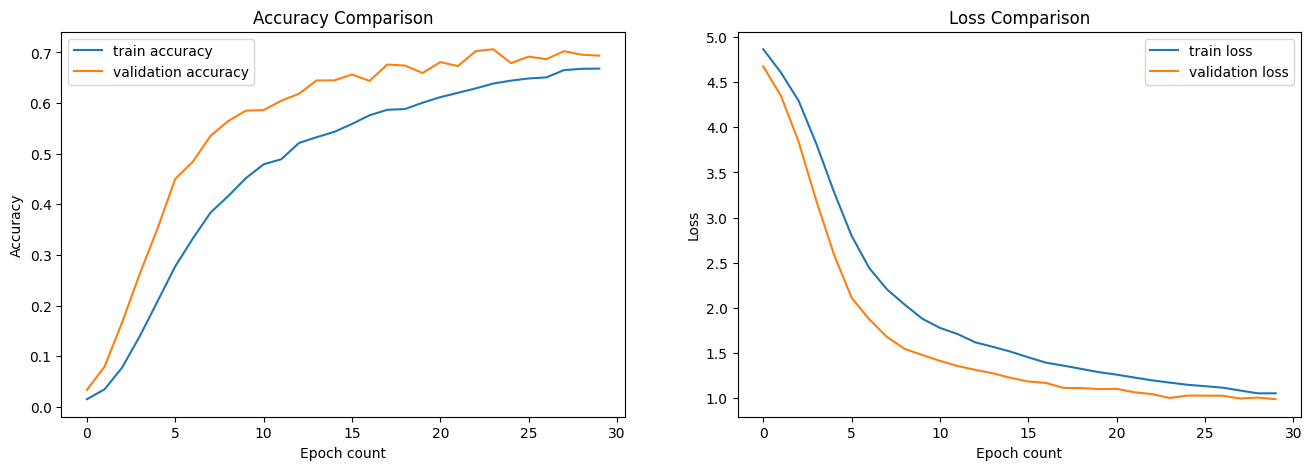

In [ ]:
plt.figure(figsize=(16,5))

plt.subplot(121)
sns.lineplot(model.history.history['acc'],label='train accuracy')
sns.lineplot(model.history.history['val_acc'],label='validation accuracy')
plt.xlabel('Epoch count')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')

plt.subplot(122)
sns.lineplot(model.history.history['loss'],label='train loss')
sns.lineplot(model.history.history['val_loss'],label='validation loss')
plt.xlabel('Epoch count')
plt.ylabel('Loss')
plt.title('Loss Comparison')